# Time Series
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ts = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

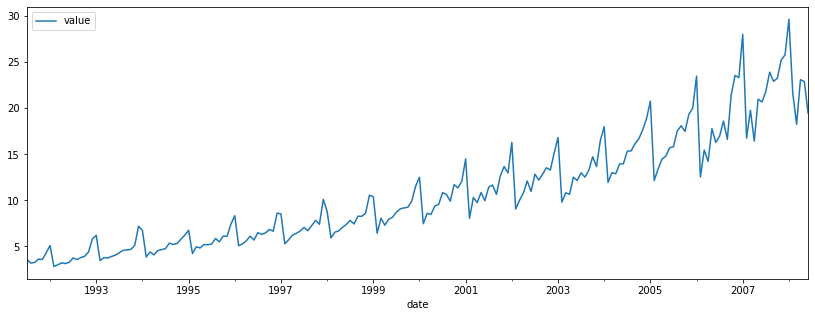

In [4]:
ts.plot(figsize=(14, 5))

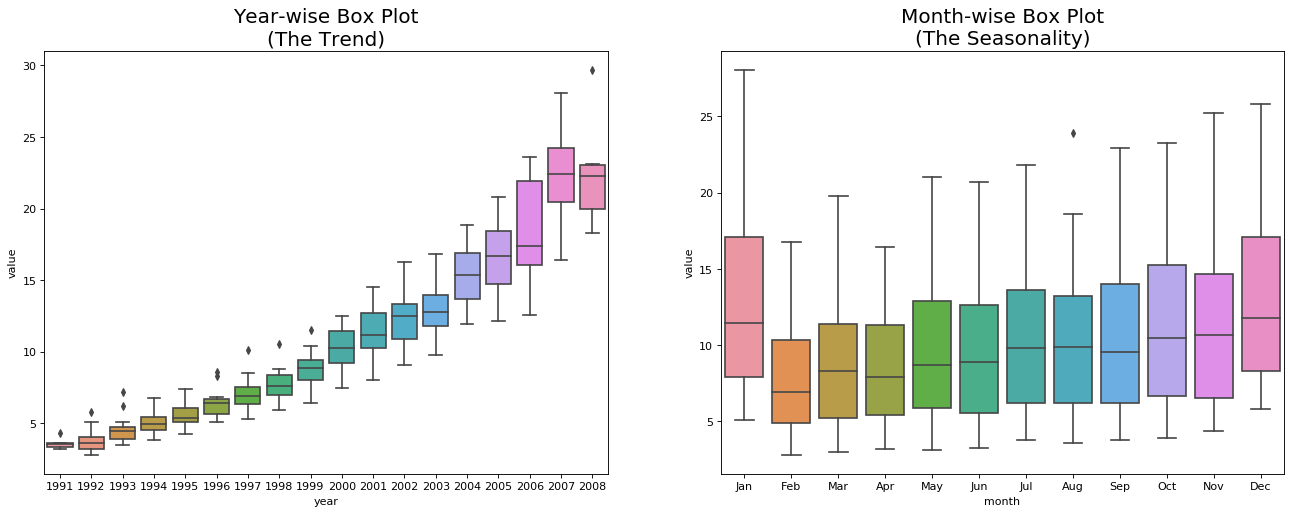

In [5]:
ts_df = ts.reset_index()

# Prepare data
ts_df['year'] = [d.year for d in ts_df.date]
ts_df['month'] = [d.strftime('%b') for d in ts_df.date]
years = ts_df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=ts_df, ax=axes[0])
sns.boxplot(x='month', y='value', data=ts_df.loc[~ts_df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## I. Decompose a time serie

- **Additive**  
*hypothesis*: s = base_value + trend + seasonality + error  
- **Multiplicative**  
*hypothesis*: s = base_value * trend * seasonality * error

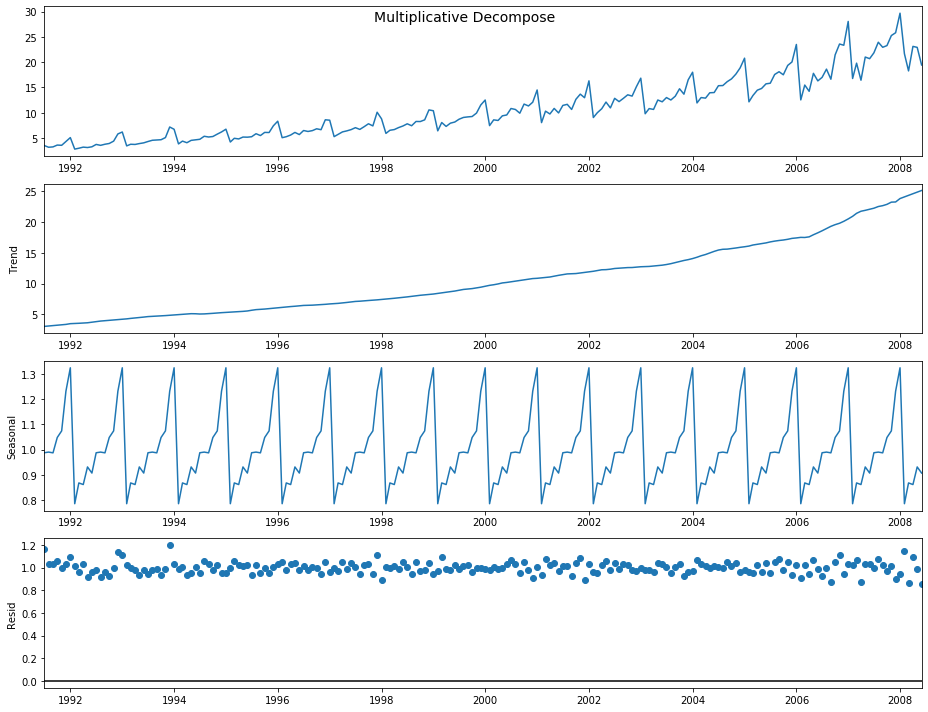

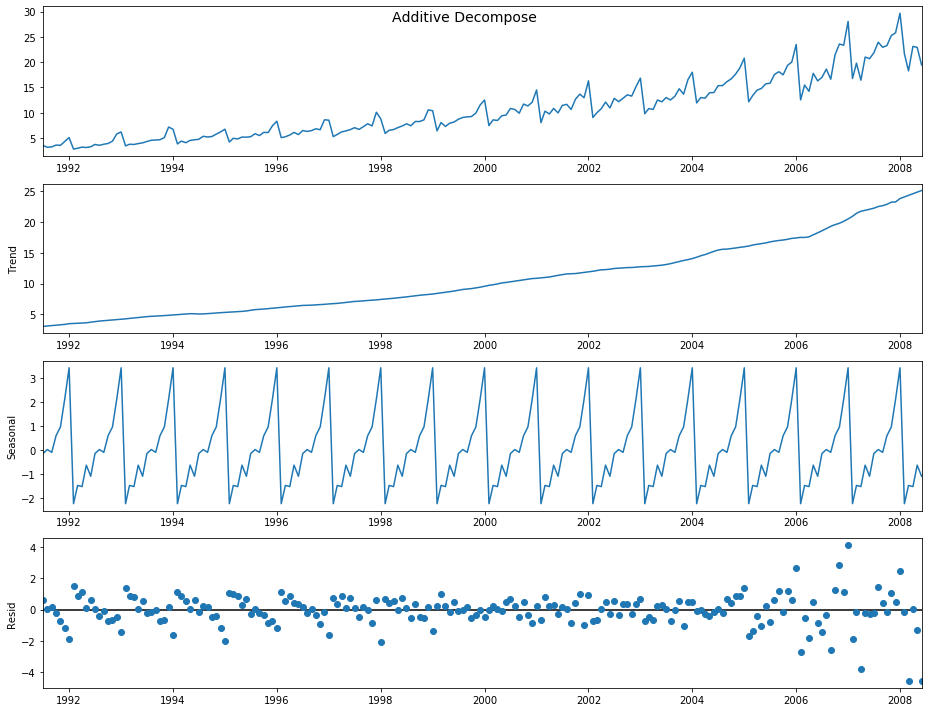

In [6]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (13,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)
result_add.plot().suptitle('Additive Decompose', fontsize=14)
plt.show()

## II. Make a time serie stationnary

### 1) Differencing

($S_{d}^t = S^t - S^{t-1}$)

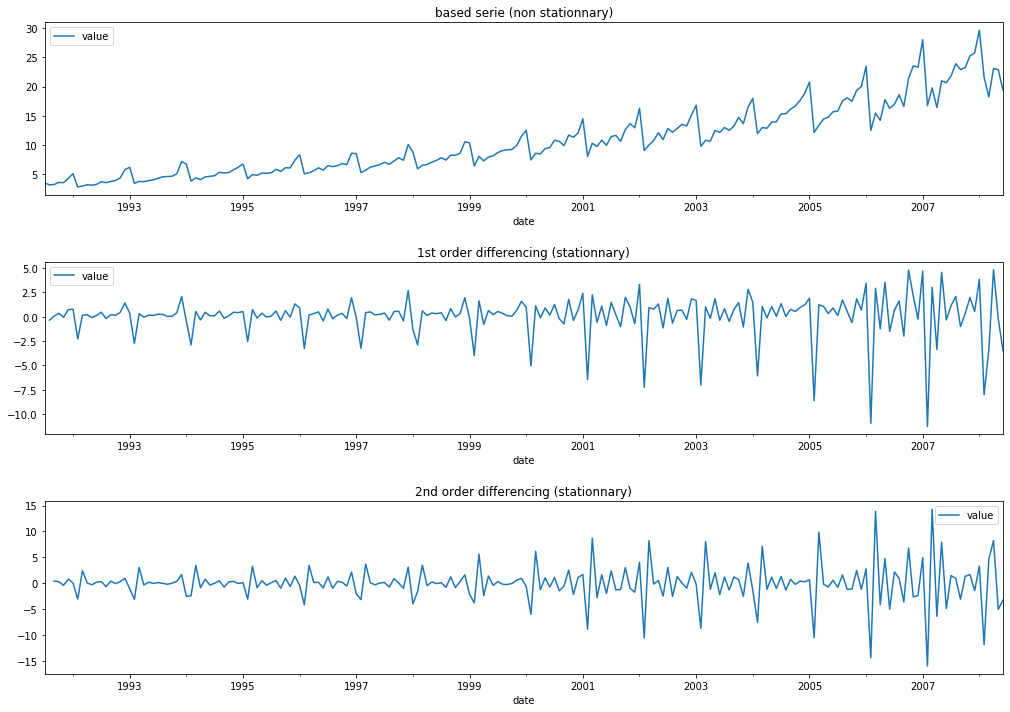

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)
ts.plot(ax=axes[0], figsize=(14, 10), title='based serie (non stationnary)')
ts.diff().plot(ax=axes[1], figsize=(14, 10), title='1st order differencing (stationnary)')
ts.diff().diff().plot(ax=axes[2], figsize=(14, 10), title='2nd order differencing (stationnary)')
fig.tight_layout(h_pad=2)

### 2) Log or Nth root

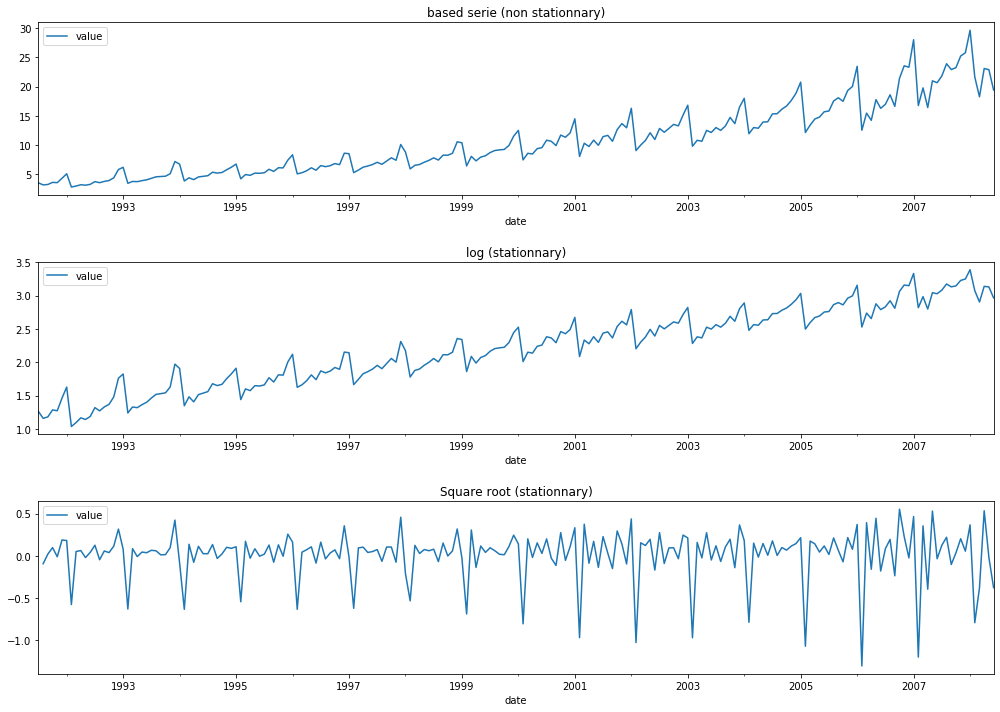

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1)
ts.plot(ax=axes[0], figsize=(14, 10), title='based serie (non stationnary)')
np.log(ts).plot(ax=axes[1], figsize=(14, 10), title='log (stationnary)')
np.sqrt(ts).diff().plot(ax=axes[2], figsize=(14, 10), title='Square root (stationnary)')
fig.tight_layout(h_pad=2)

## III. Detrend a time serie

### 1) Linear regression method

Substract the best fit from a linear regression on the serie

In [9]:
from sklearn.linear_model import LinearRegression
X = ((ts.index -  ts.index[0]).days).to_numpy().reshape(-1, 1)
lr = LinearRegression().fit(X, ts)

In [10]:
best_fit = pd.Series(X.T[0]*lr.coef_[0] + lr.intercept_, index=ts.index, name='best fit linear regression')

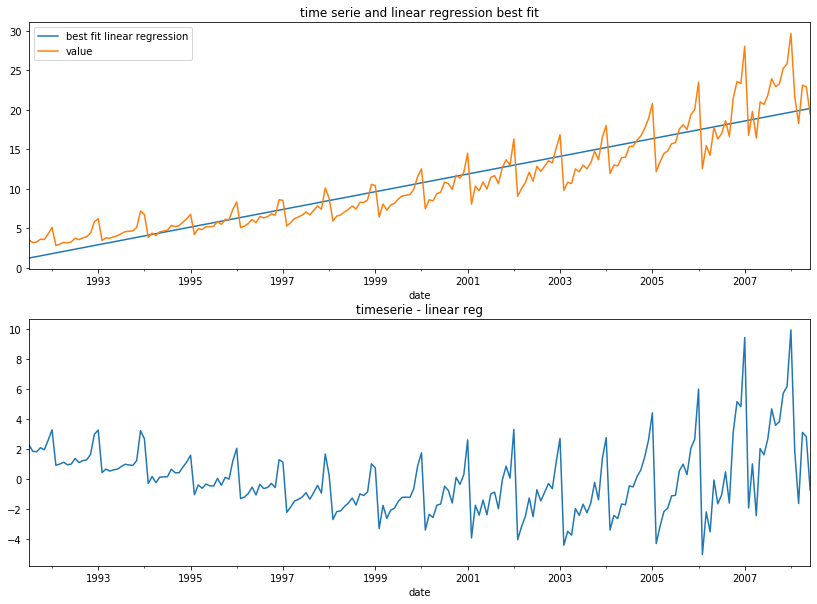

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)
best_fit.plot(ax=axes[0], figsize=(14, 10), title='time serie and linear regression best fit', legend=True)
ts.value.plot(ax=axes[0], legend=True)
(ts.value - best_fit).plot(ax=axes[1], figsize=(14, 10), title='timeserie - linear reg')

### 2) Trend from time serie decomposition

Substract the trend from time serie decomposition

In [166]:
decomp = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

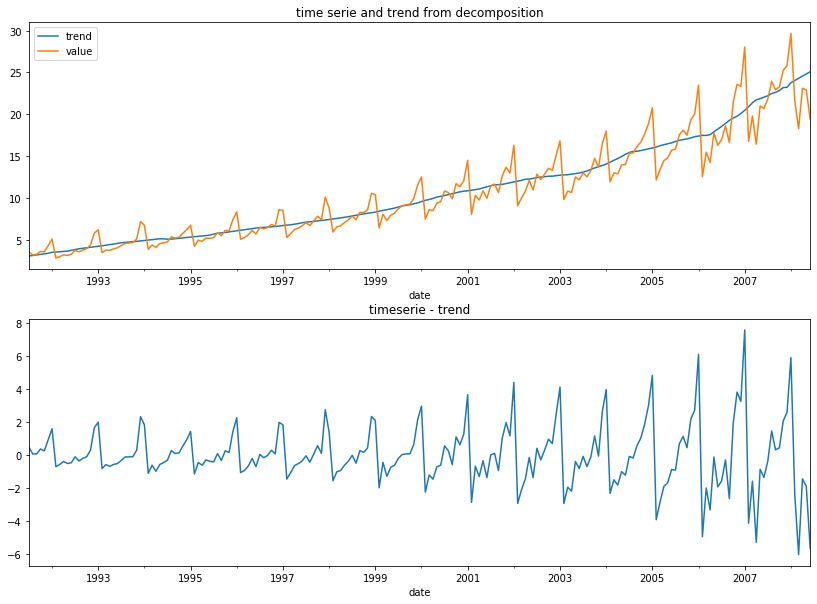

In [170]:
fig, axes = plt.subplots(nrows=2, ncols=1)
decomp.trend.plot(ax=axes[0], figsize=(14, 10), title='time serie and trend from decomposition', legend=True)
ts.value.plot(ax=axes[0], legend=True)
(ts.value - decomp.trend).plot(ax=axes[1], figsize=(14, 10), title='timeserie - trend')

## IV. Deseasonalize a time serie

### 1) Rolling average with a right season period

In this example, the same pattern repeats every year.

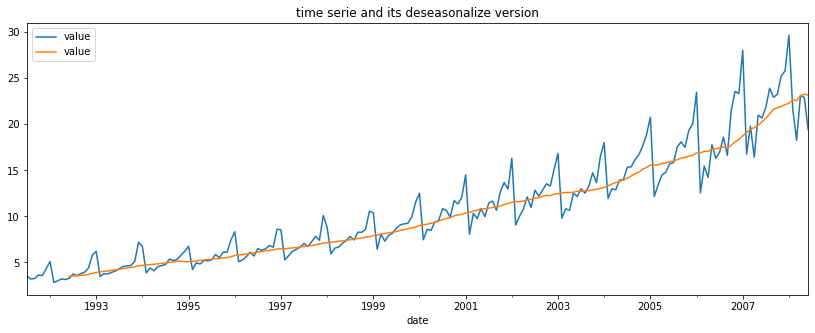

In [12]:
seasonal_window = 12
ax = ts.plot(figsize=(14, 5), title='time serie and its deseasonalize version', legend=True)
ts.value.rolling(seasonal_window).mean().plot(ax=ax, legend=True)

### 2) Seasonality from time serie decomposition

Substract the Seasonality from time serie decomposition

In [13]:
decomp = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

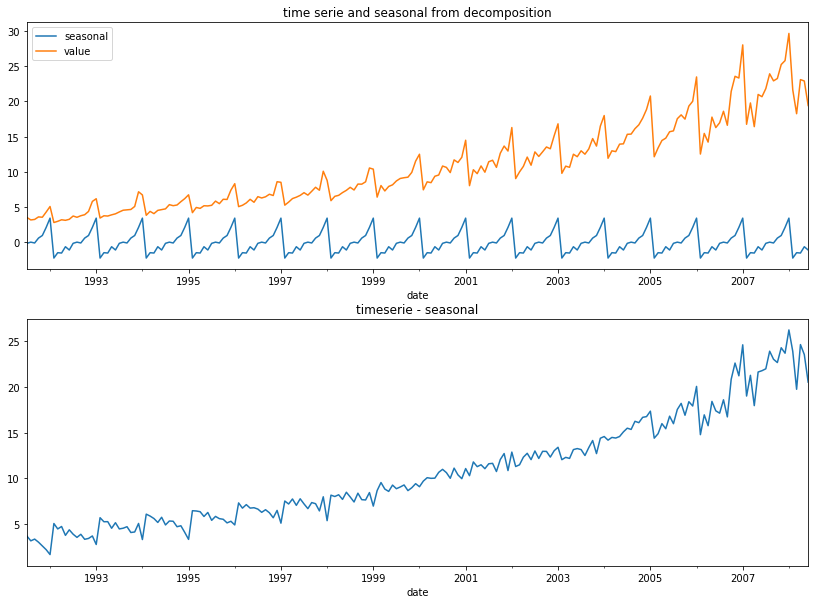

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1)
decomp.seasonal.plot(ax=axes[0], figsize=(14, 10), title='time serie and seasonal from decomposition', legend=True)
ts.value.plot(ax=axes[0], legend=True)
(ts.value - decomp.seasonal).plot(ax=axes[1], figsize=(14, 10), title='timeserie - seasonal')

## Handle Missing Values 

To evaluate our differents methods we use the MSE. 

In [105]:
from copy import deepcopy
from scipy.interpolate import interp1d
ts_incomplete = deepcopy(ts.reset_index())
nan_index = np.random.choice(range(1, len(ts) - 1), size=(30, ))
ts_incomplete.loc[nan_index, 'value'] = np.nan
ts_incomplete.set_index('date', inplace=True)

In [106]:
def MSE(true, pred):
    return round(float(np.mean((true - pred)**2)), 3)

In [107]:
ts_incomplete["rownum"] = np.arange(ts_incomplete.shape[0])
ts_incomplete_dropna = ts_incomplete.dropna(subset=['value'])
interp_linear = interp1d(ts_incomplete_dropna.rownum, ts_incomplete_dropna.value)
interp_cubic = interp1d(ts_incomplete_dropna.rownum, ts_incomplete_dropna.value, kind='cubic')

ts_bfill = ts_incomplete.value.bfill()
ts_ffill = ts_incomplete.value.ffill()
ts_interp_linear = pd.Series(interp_linear(ts_incomplete.rownum), index=ts_incomplete.index)
ts_interp_cubic = pd.Series(interp_cubic(ts_incomplete.rownum), index=ts_incomplete.index)

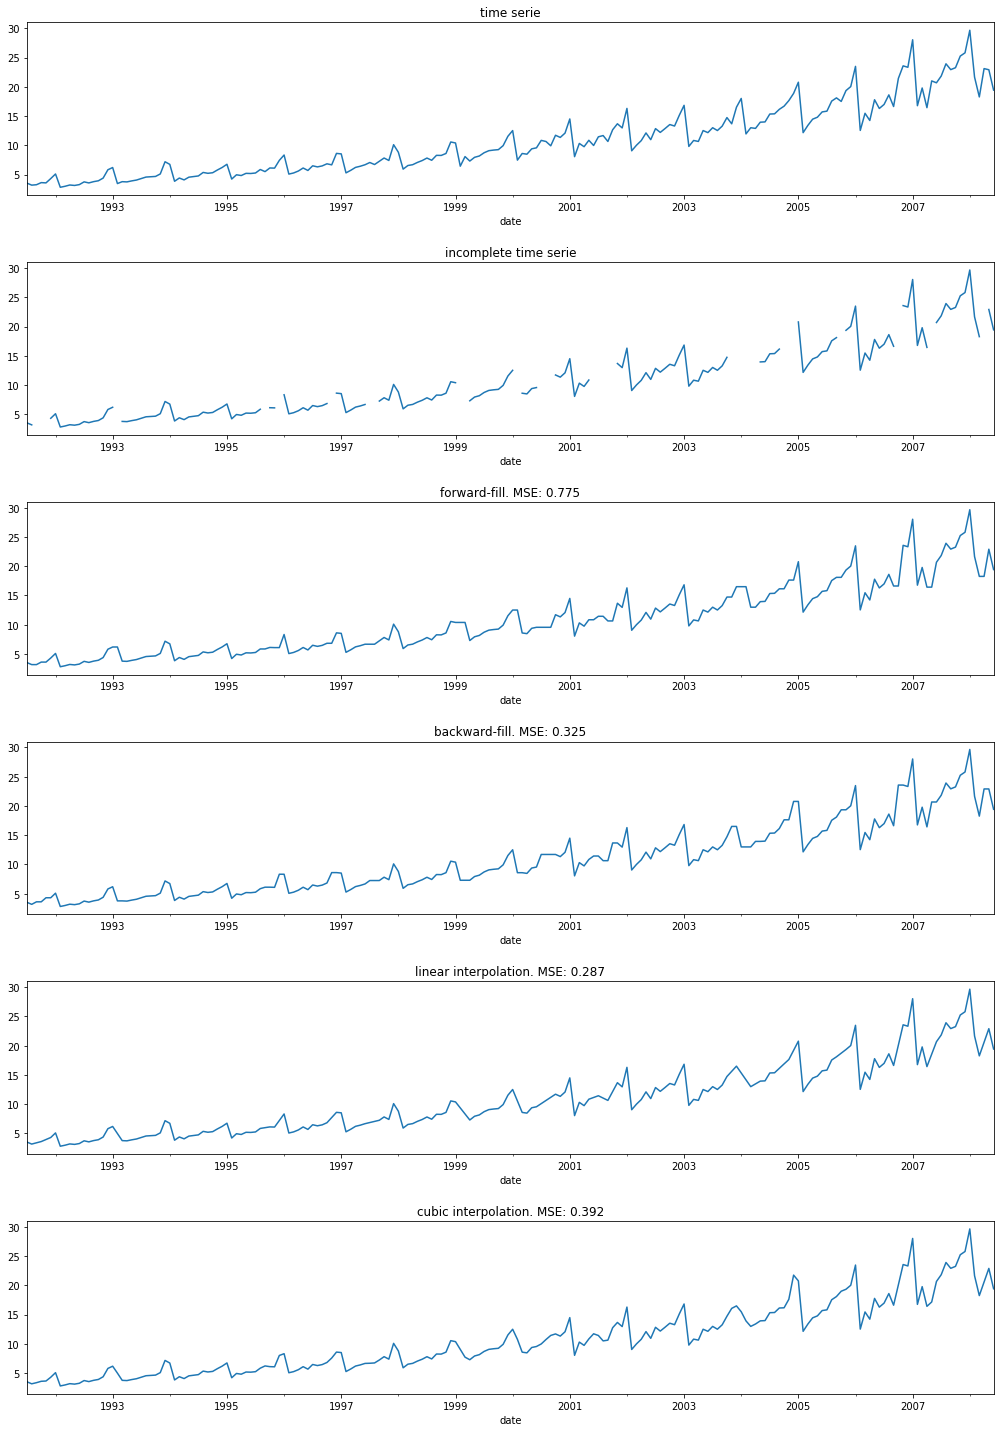

In [113]:
fig, axes = plt.subplots(nrows=6, ncols=1)
ts.value.plot(ax=axes[0], figsize=(14, 20), title=f'time serie')
ts_incomplete.value.plot(ax=axes[1], figsize=(14, 20), title=f'incomplete time serie')
ts_ffill.plot(ax=axes[2],figsize=(14, 20), 
              title=f'forward-fill. MSE: {MSE(ts.value, ts_ffill)}')
ts_bfill.plot(ax=axes[3],figsize=(14, 20), 
              title=f'backward-fill. MSE: {MSE(ts.value, ts_bfill)}')
ts_interp_linear.plot(ax=axes[4],figsize=(14, 20), 
                      title=f'linear interpolation. MSE: {MSE(ts.value, ts_interp_linear)}')
ts_interp_cubic.plot(ax=axes[5],figsize=(14, 20), 
                     title=f'cubic interpolation. MSE: {MSE(ts.value, ts_interp_cubic)}')
fig.tight_layout(h_pad=2)